In [1]:
"""
    Get cleaned data
"""

import numpy as np

dataset = np.load('./datasets/spectro4ch.npy')
labels = np.load('./datasets/labels.npy')

In [2]:
"""
    Split dataset
"""

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
shuf_dataset, shuf_labels = shuffle(dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(shuf_dataset, shuf_labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(y_train.shape)
print(X_train.shape)

Train set size: 622, Val set size: 134, Test set size: 133
(622,)
(622, 4, 100, 100)


In [4]:
"""
    Model and train
"""

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = './models/'
json_name = 'MLP_Spectro.json'
weight_name = 'MLP_Spectro_tmp.h5'

batch_size = 24
epochs = 128
num_classes = 2

N_train = X_train.shape[0]
N_test = X_test.shape[0]
N_val = X_val.shape[0]

X_train = X_train.reshape(N_train, -1)
X_test = X_test.reshape(N_test, -1)
X_val = X_val.reshape(N_val, -1)
input_dim = X_train.shape[1]

print("Constructing MLP Model: ...", end='')
model = Sequential()
# Input
model.add(Dense(512, input_dim=input_dim, activation='relu'))

# Hidden
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1, noise_shape=None, seed=None))
model.add(Dense(12, activation='relu'))

# Classification
model.add(Dense(1, activation='sigmoid'))
print(" Complete.")
model.summary()

print("Compiling MLP Model: ...", end='')
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(" Complete.")

#earlyStop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
mcp_save = ModelCheckpoint(filepath=model_path+weight_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_delta=1e-4, mode='min')

print("Fitting MLP Model: ...")
#results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[mcp_save], validation_data=(X_val, y_val), shuffle=True)
print("Complete.")

Constructing MLP Model: ... Complete.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               20480512  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 96

In [7]:
"""
    Save the model
"""

model_path = './models/'
json_name = 'MLP_Spectro.json'
weight_name = 'MLP_Spectro.h5'

model_json = model.to_json()
with open(model_path+json_name, 'w') as json_file:
    json_file.write(model_json)
#model.save_weights(model_path+weight_name)

133/133 [==============================] - 0s 1ms/step

Final test acc: 63.91%


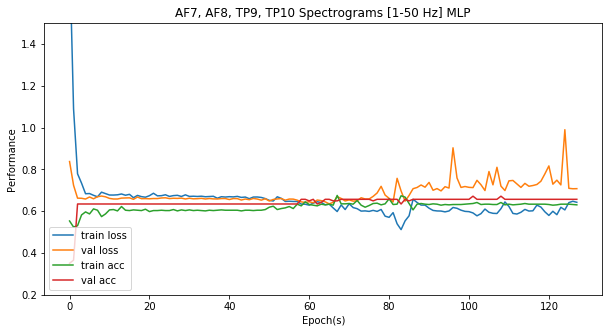

In [10]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'MLP_Spectro_2to1.png'

fig = plt.figure(figsize=(10,5))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.ylim((0.2,1.5))
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Spectrograms [1-50 Hz] MLP')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')
test_scores = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

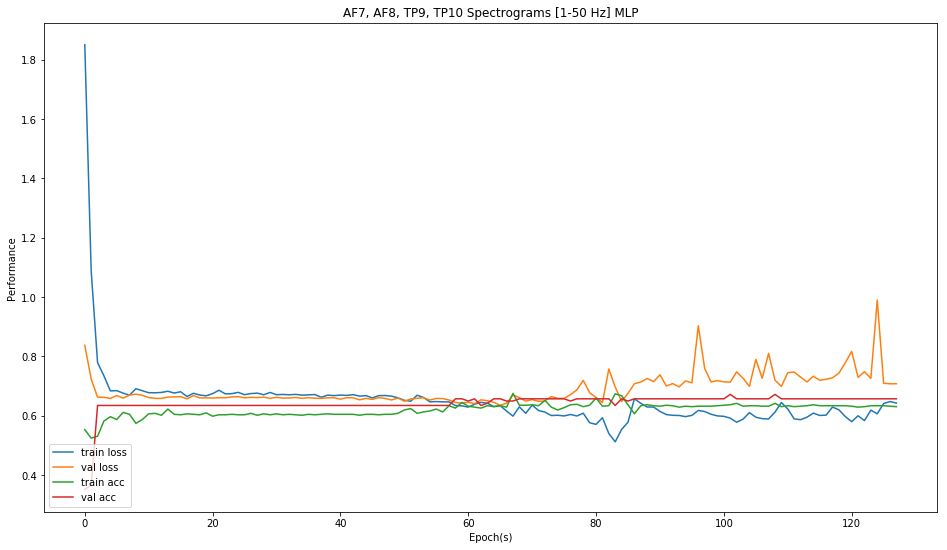

In [11]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'MLP_Spectro_16to9.png'

fig = plt.figure(figsize=(16,9))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Spectrograms [1-50 Hz] MLP')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')

In [12]:
"""
    Try fetching the model
"""

from keras.models import model_from_json

json_file = open(model_path+json_name)
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights(model_path+weight_name)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loaded_test_score = loaded_model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (loaded_model.metrics_names[1], loaded_test_score[1]*100))

133/133 [==============================] - 0s 3ms/step

Final test acc: 63.91%
